# Preparing the Data
## Importing packages

In [82]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from scipy.stats import zscore

import os

## Reading in data

In [83]:
project_root = os.getcwd()  # Assumes script runs from project root

# Define the path to the processed data folder
data_path = os.path.join(project_root, "..", "data", "processed")

# Load the CSV files
customer_df = pd.read_csv(os.path.join(data_path, "customer.csv"))
digital_usage_df = pd.read_csv(os.path.join(data_path, "digital_usage.csv"))
transactions_df = pd.read_csv(os.path.join(data_path, "transactions.csv"))
loans_df = pd.read_csv(os.path.join(data_path, "loans.csv"))
products_df = pd.read_csv(os.path.join(data_path, "products_owned.csv"))

## Ensure dates are in the right format

In [84]:
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])
loans_df["due_date"] = pd.to_datetime(loans_df["due_date"])
loans_df["paid_off_date"] = pd.to_datetime(loans_df["paid_off_date"])

## Creating interaction terms

### Transaction Table
Since days_from_last_transaction is calculated using the current date so this particular value will be changing everyday. We calculate days_from_last_transaction and num_transactions from the transactions table

In [85]:
### Calculate days_from_last_transaction and num_transactions
latest_transaction = transactions_df.groupby("customer_id")["transaction_date"].max().reset_index()
latest_transaction["days_from_last_transaction"] = (pd.to_datetime("today") - latest_transaction["transaction_date"]).dt.days
latest_transaction = latest_transaction[["customer_id", "days_from_last_transaction"]]
### Calculate avg_transaction_amt per customer
transaction_summary = transactions_df.groupby("customer_id").agg(total_transaction_amt=("transaction_amt", "sum"),num_transactions=("transaction_id", "count")).reset_index()
transaction_summary["avg_transaction_amt"] = transaction_summary["total_transaction_amt"] / transaction_summary["num_transactions"]
transaction_summary = transaction_summary[["customer_id", "avg_transaction_amt", "num_transactions"]]

### Digital Usage table

This code computes a digital engagement score for each customer based on their online activity.
    
Combine both metrics into a weighted score:

- Logins (70%) contribute more since frequent logins indicate active engagement.
- Session time (30%) contributes less but still matters.

In [86]:
# Calculate digital engagement score
scaler = MinMaxScaler()
digital_usage_df["normalized_logins"] = scaler.fit_transform(digital_usage_df[["mobile_logins_wk", "web_logins_wk"]].sum(axis=1).values.reshape(-1, 1))
digital_usage_df["normalized_session_time"] = scaler.fit_transform(digital_usage_df[["avg_mobile_time", "avg_web_time"]].sum(axis=1).values.reshape(-1, 1))
digital_usage_df["digital_engagement_score"] = (digital_usage_df["normalized_logins"] * 0.7 +digital_usage_df["normalized_session_time"] * 0.3)
# Correct aggregation step
digital_engagement = digital_usage_df.groupby("customer_id", as_index=False)["digital_engagement_score"].mean()

### Loans table

This code calculates the median loan repayment time for each customer, which helps identify financial reliability.

In [87]:
# Median loan repayment time per customer
loans_df["loan_repayment_time"] = (loans_df["paid_off_date"] - loans_df["due_date"]).dt.days
loan_summary = loans_df.groupby("customer_id")["loan_repayment_time"].median().reset_index()

### Products table

This code calculates the total number of financial products a customer owns from the bank, which helps measure their relationship with the bank.

In [88]:
# Total products owned
products_df["total_products_owned"] = products_df.iloc[:, 1:].sum(axis=1)
products_summary = products_df[["customer_id", "total_products_owned"]]

### Customer table

This code selects relevant financial and behavioral attributes from the customer dataset to be used in segmentation.

In [89]:
# Extracting relevant columns from customer table
customer_features = ['customer_id', 'income', 'balance', 'customer_lifetime_value', 'debt', 'tenure', 'default']
customer_subset_df = customer_df[customer_features]

## Merging datasets

In [90]:
df = customer_subset_df.merge(latest_transaction, on="customer_id", how="left")
df = df.merge(transaction_summary[["customer_id", "avg_transaction_amt", "num_transactions"]], on="customer_id", how="left")
df = df.merge(digital_engagement[["customer_id", "digital_engagement_score"]], on="customer_id", how="left")
df = df.merge(loan_summary, on="customer_id", how="left")
df = df.merge(products_df[["customer_id", "total_products_owned"]], on="customer_id", how="left")
print(df.head())

   customer_id   income   balance  customer_lifetime_value      debt  tenure  \
0          166  1456.22 -10837.70                   214.12  38473.44      31   
1          139   597.64  -8163.90                   255.79  96402.54      20   
2          484   822.64  -7492.65                   129.42   9731.79      36   
3          508   340.44  -5520.04                   125.30  18799.09      29   
4          119  1022.64  -5071.99                   347.16  19080.59      36   

   default  days_from_last_transaction  avg_transaction_amt  num_transactions  \
0        1                         NaN                  NaN               NaN   
1        1                         NaN                  NaN               NaN   
2        1                         NaN                  NaN               NaN   
3        1                       251.0              109.536               5.0   
4        1                         NaN                  NaN               NaN   

   digital_engagement_score  loa

In [91]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 4000 non-null   int64  
 1   income                      4000 non-null   float64
 2   balance                     4000 non-null   float64
 3   customer_lifetime_value     4000 non-null   float64
 4   debt                        4000 non-null   float64
 5   tenure                      4000 non-null   int64  
 6   default                     4000 non-null   int64  
 7   days_from_last_transaction  1844 non-null   float64
 8   avg_transaction_amt         1844 non-null   float64
 9   num_transactions            1844 non-null   float64
 10  digital_engagement_score    3981 non-null   float64
 11  loan_repayment_time         2629 non-null   float64
 12  total_products_owned        4000 non-null   int64  
dtypes: float64(9), int64(4)
memory us

In [92]:
print(df.isnull().sum())

customer_id                      0
income                           0
balance                          0
customer_lifetime_value          0
debt                             0
tenure                           0
default                          0
days_from_last_transaction    2156
avg_transaction_amt           2156
num_transactions              2156
digital_engagement_score        19
loan_repayment_time           1371
total_products_owned             0
dtype: int64


## Handling missing values
`digital_engagement_score` only has 19 missing values so we can use KNN Inputer
`avg_transaction_amt` is NaN means no transaction data found so we set NaN to be 0
`days_from_last_transaction` is NaN means no transaction data. We set last transaction number of days to be large but not too extreme. 
`has_loan` is NaN means no data on loans taken for that customer, We set NaN values to be 0. For those who has loaned before but but those with loans but no date of payment, we set the NaN values to be large but not too extreme

Warning due to potential issues in future version of pandas


This code helps handles missing values

1. digital engagement scores: Uses KNN Imputer (k=5) to estimate missing values based on similar customers.
2. Handle missing transaction-related data:
- If no transaction records exist: 
    - avg_transaction_amt = 0 (customer hasn't spent anything); num_transactions = 0 (customer hasn't made any transactions).
    - assume a long but reasonable inactivity period (set to the max inactivity + 30 days).
3. Handle missing loan-related data:
- Create a new variable has_loan:
    - 1 if the customer has taken a loan.
    - 0 if they have never taken a loan.
    - If they had a loan but never repaid it, set loan_repayment_time to max repayment time + 30 days as a buffer.


In [93]:
### engagement score only has 19 missing values
df["digital_engagement_score"] = KNNImputer(n_neighbors=5).fit_transform(df[["digital_engagement_score"]])
### no transaction record (we set transactions to be 0)
df["avg_transaction_amt"].fillna(0, inplace=True)
df["num_transactions"].fillna(0, inplace=True)
### some did not do transactions. we set the days from last transaction to be a high but not too extreme value. We add 2 months of buffer
df["days_from_last_transaction"].fillna(df["days_from_last_transaction"].max() + 30, inplace=True)
### clients who did not loan before, we set has_loan variable to 0. for those that has loaned but hasnt repaid will have repayment time of max repayment time + buffer of a month
df["has_loan"] = df["customer_id"].isin(loans_df["customer_id"]).astype(int)
loan_repay_max = df["loan_repayment_time"].max()
df["loan_repayment_time"] = df.apply(lambda row: 0 if row["has_loan"] == 0 else (loan_repay_max + 30 if np.isnan(row["loan_repayment_time"]) else row["loan_repayment_time"]),axis=1)


/var/folders/wc/5cwlt66x6d12kf_tz4qkd_580000gn/T/ipykernel_25060/2937541440.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["avg_transaction_amt"].fillna(0, inplace=True)
/var/folders/wc/5cwlt66x6d12kf_tz4qkd_580000gn/T/ipykernel_25060/2937541440.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [94]:
print(df.isnull().sum())

customer_id                   0
income                        0
balance                       0
customer_lifetime_value       0
debt                          0
tenure                        0
default                       0
days_from_last_transaction    0
avg_transaction_amt           0
num_transactions              0
digital_engagement_score      0
loan_repayment_time           0
total_products_owned          0
has_loan                      0
dtype: int64


# Check for outliers

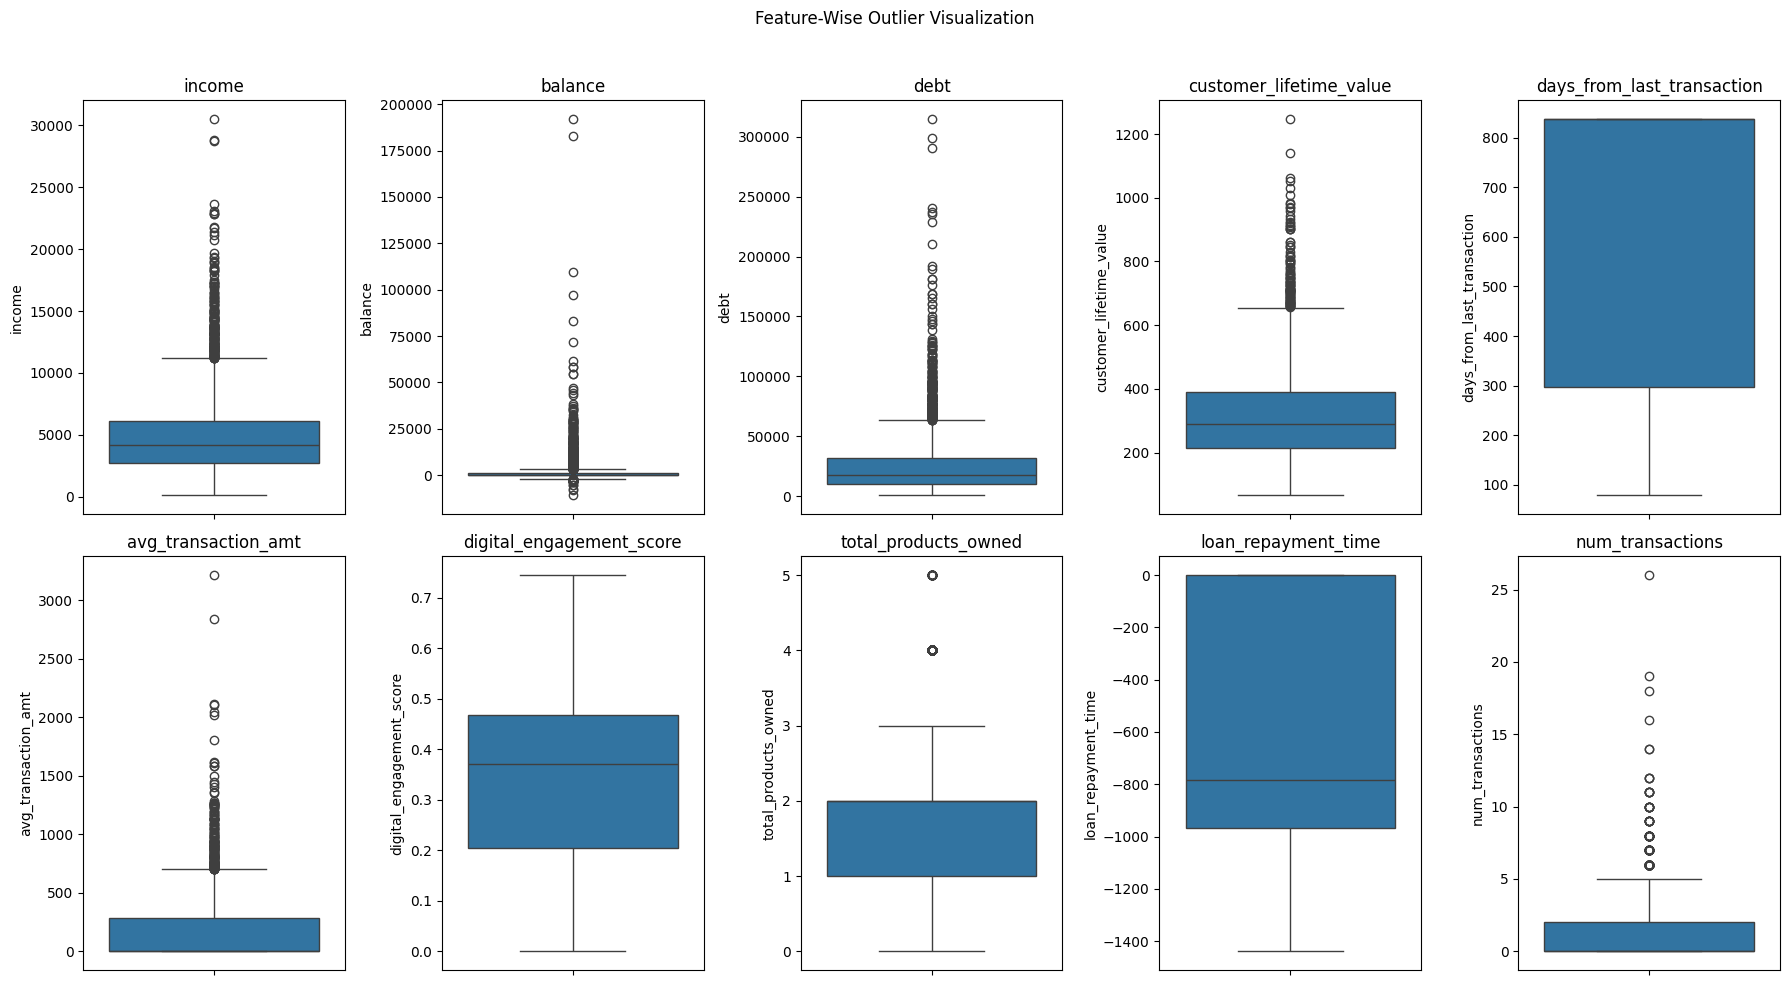

In [95]:
# Check for outliers
features_to_scale = ["income", "balance", "debt", "customer_lifetime_value", 
                    "days_from_last_transaction", "avg_transaction_amt", 
                    "digital_engagement_score", "total_products_owned", 
                    "loan_repayment_time", "num_transactions"]

# Individual boxplots for better clarity
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 10))
fig.suptitle("Feature-Wise Outlier Visualization")

for i, feature in enumerate(features_to_scale):
    row, col = divmod(i, 5)
    sns.boxplot(y=df[feature], ax=axes[row][col])
    axes[row][col].set_title(feature)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [96]:
# Define function to count outliers using Z-score method
def count_outliers_zscore(df, threshold=3):
    outlier_counts = {}

    for col in df.select_dtypes(include=[np.number]): 
        z_scores = np.abs(zscore(df[col])) 
        num_outliers = (z_scores > threshold).sum()
        outlier_counts[col] = num_outliers

    return pd.DataFrame.from_dict(outlier_counts, orient="index", columns=["Outlier Count"])


# Apply to dataset
outliers_zscore_df = count_outliers_zscore(df)
print(outliers_zscore_df)


                            Outlier Count
customer_id                             0
income                                 70
balance                                50
customer_lifetime_value                49
debt                                   68
tenure                                 17
default                                 0
days_from_last_transaction              0
avg_transaction_amt                    70
num_transactions                       53
digital_engagement_score                0
loan_repayment_time                     0
total_products_owned                   30
has_loan                                0


# Standardizing

We apply Winsorization (limits=[0.05, 0.05]) to cap extreme values at the 5st and 95th percentiles as outliers for in the `robust_features` column are very extreme. To standardize these columns, we use

RobustScaler(), which:
- Centers the median at 0 and scales data based on the interquartile range (IQR).
- Less sensitive to outliers than StandardScaler or MinMaxScaler.

For the other features, we use:

StandardScaler(), which:
Centers mean at 0 and scales variance to 1.
Works well for features without extreme outliers.

In [97]:
## STANDARDIZING FOR K-MEANS CLUSTERING
# Features that need Robust scaling 
robust_features = ["income", "balance", "debt", "customer_lifetime_value",  "avg_transaction_amt"]
for col in robust_features:
    df[col] = pd.Series(winsorize(df[col].to_numpy(), limits=[0.05, 0.05]))


# Features that need Standard scaling (normally distributed)
standard_features = ["days_from_last_transaction", "digital_engagement_score", "total_products_owned", "loan_repayment_time", "num_transactions"]

# Apply RobustScaler
scalerrobust =  RobustScaler()
df_scaled = df.copy()
df_scaled[robust_features] = scalerrobust.fit_transform(df[robust_features])

# Apply StandardScaler
scaler_standard = StandardScaler()
df_scaled[standard_features] = scaler_standard.fit_transform(df[standard_features])

# PCA Analysis

This code performs Principal Component Analysis (PCA) to analyze how much variance each feature contributes to the dataset. explained_variance_ratio_: Measures how much variance each principal component captures.

In [98]:
# Apply PCA
pca = PCA(n_components=len(features_to_scale))  # Keep all components
df_pca = pca.fit_transform(df_scaled[features_to_scale])

# Convert to DataFrame
explained_variance = pd.DataFrame(
    pca.explained_variance_ratio_,
    index=features_to_scale,
    columns=["Explained Variance"]
)

# Print explained variance of each feature
print("\nPCA Explained Variance:\n", explained_variance.sort_values(by="Explained Variance", ascending=False))


PCA Explained Variance:
                             Explained Variance
income                                0.341577
balance                               0.209314
debt                                  0.115268
customer_lifetime_value               0.097747
days_from_last_transaction            0.076951
avg_transaction_amt                   0.067203
digital_engagement_score              0.044457
total_products_owned                  0.024302
loan_repayment_time                   0.017096
num_transactions                      0.006085


In [99]:
features = df.columns
print(features)

Index(['customer_id', 'income', 'balance', 'customer_lifetime_value', 'debt',
       'tenure', 'default', 'days_from_last_transaction',
       'avg_transaction_amt', 'num_transactions', 'digital_engagement_score',
       'loan_repayment_time', 'total_products_owned', 'has_loan'],
      dtype='object')


# Modeling

## K-Means Clustering
We use k = 3 to segment the customers into 3 categories 
1. High value
2. Budget conscious
3. At risk / inactive customers

In [100]:
## K-MEANS CLUSTERING
optimal_k = 3
df_scaled["Cluster"] = KMeans(n_clusters= optimal_k,  init="k-means++", n_init=20, random_state=42).fit_predict(df_scaled[features_to_scale])
df["Cluster"] = df_scaled["Cluster"]

### Number of clients in each cluster

In [101]:
print(df["Cluster"].value_counts())

Cluster
1    2106
2    1440
0     454
Name: count, dtype: int64


# Evaluation: Silhouette Score
 This score shows how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

In [102]:
# Silhouette Score
silhouette_avg = silhouette_score(df_scaled[features_to_scale], df["Cluster"])
print(f"Silhouette Score = {silhouette_avg:.4f}")

Silhouette Score = 0.2401


Silhouette Score = 0.2401, indicating that while the segments have meaningful distinctions, there is moderate overlap between customer groups. Customer data typically includes heterogeneous characteristics (e.g., behavioral, transactional, demographic attributes) that naturally reduce clear separations between segments. The segments are designed based on business logic (engagement, spending, product usage),even if silhouette metrics aren't exceptionally high.

### Getting information about each cluster's mean of features

In [103]:
cluster_means = df_scaled.groupby("Cluster")[features_to_scale].mean()
print(cluster_means)

           income   balance      debt  customer_lifetime_value  \
Cluster                                                          
0        1.808443  4.916250  0.313674                 0.338305   
1       -0.059192  0.122906  0.260786                 0.070790   
2        0.015168  0.216871  0.237387                 0.115215   

         days_from_last_transaction  avg_transaction_amt  \
Cluster                                                    
0                          0.065377             0.555509   
1                          0.758580             0.065163   
2                         -1.130035             1.260182   

         digital_engagement_score  total_products_owned  loan_repayment_time  \
Cluster                                                                        
0                       -0.116567              0.398223             0.045314   
1                        0.025407             -0.084005            -0.011844   
2                       -0.000407             -0

## Cluster Labels
We assign higher weights for critical factors that define customer value:
- income (10%) → High value customers likely to be more financially healthy
- balance (10%) → Same reason as above
- customer_lifetime_value (15%) → Long-term revenue predictor.
- avg_transaction_amt (20%) → High-value customers spend more per transaction.
- digital_engagement_score (20%) → Engaged customers are more valuable.
- total_products_owned (20%) → Owning multiple products strengthens customer loyalty.
- num_transactions (20%) → Frequent transactions signal active customers.



Penalty for inactivity:
- days_from_last_transaction (- 20%) → Longer inactivity lowers score.
Slight penalty for financial distress:
- debt (-5%) → High debt can indicate financial risk.

We assign segments dynamically based on rankings
- Top cluster = High-Value
- 2rd highest = Budget-Conscious
- Last = Inactive


In [104]:
cluster_means["score"] = (
    cluster_means["income"] * 0.1 + 
    cluster_means["balance"] * 0.1 + 
    cluster_means["debt"] * (-0.05) +  # Negative weight for financial distress
    cluster_means["customer_lifetime_value"] * 0.15 +  # Increased because CLV predicts revenue
    cluster_means["days_from_last_transaction"] * (-0.20) +  # Increased penalty for inactivity
    cluster_means["avg_transaction_amt"] * 0.20 +  # High-value customers spend more per transaction
    cluster_means["digital_engagement_score"] * 0.20 +  # More engagement means higher retention
    cluster_means["total_products_owned"] * 0.20 +  # Owning more products = stronger banking relationship
    cluster_means["num_transactions"] * 0.20  # Higher impact because frequent usage matters
)


# Rank Clusters Based on Score (Descending)
sorted_clusters = cluster_means["score"].sort_values(ascending=False).index.tolist()

# Assign Segments Based on Rank
dynamic_segment_mapping = {
    sorted_clusters[0]: "High-value",
    sorted_clusters[1]: "Budget-conscious",
    sorted_clusters[2]: "At risk / inactive customers"
}

# Print cluster rankings before applying
print("\nCluster Ranking by Score (Best to Worst):")
for i, cluster in enumerate(sorted_clusters):
    print(f"Rank {i+1}: Cluster {cluster} → {dynamic_segment_mapping[cluster]}")


Cluster Ranking by Score (Best to Worst):
Rank 1: Cluster 0 → High-value
Rank 2: Cluster 2 → Budget-conscious
Rank 3: Cluster 1 → At risk / inactive customers


# Creating DF with the segments

In [105]:
# Apply Mapping to DataFrame
df["Segment"] = df["Cluster"].map(dynamic_segment_mapping)
print(df["Segment"].value_counts())

Segment
At risk / inactive customers    2106
Budget-conscious                1440
High-value                       454
Name: count, dtype: int64


In [106]:
df_final = df[["customer_id", "Segment"]]
print(df_final.head())

   customer_id                       Segment
0          166  At risk / inactive customers
1          139  At risk / inactive customers
2          484  At risk / inactive customers
3          508              Budget-conscious
4          119  At risk / inactive customers


In [107]:
# Getting information of these segments
segment_means = df.groupby("Segment")[features_to_scale].mean()
# Display the results
print("Mean of original features per segment:")
print(segment_means)

Mean of original features per segment:
                                    income      balance          debt  \
Segment                                                                 
At risk / inactive customers   3967.144316   542.816249  23809.712061   
Budget-conscious               4218.300743   663.819493  23310.792896   
High-value                    10275.203106  6715.409604  24937.428590   

                              customer_lifetime_value  \
Segment                                                 
At risk / inactive customers               301.993324   
Budget-conscious                           309.821257   
High-value                                 349.130176   

                              days_from_last_transaction  avg_transaction_amt  \
Segment                                                                         
At risk / inactive customers                  817.808167            18.344129   
Budget-conscious                              274.768056          

## Creates csv table in under customer segmentation

In [108]:
df_final.to_csv("customer_segments.csv", index=False)
print("Saved 'customer_segments.csv' with Customer ID & segment name")

Saved 'customer_segments.csv' with Customer ID & segment name
